# Sprint 2: Schema Design

#### Initial configuration and conection to duckdb and ducklake

In [1]:
import duckdb
import pandas as pd
import os
import glob

# --- 1. Configuration & Paths ---
RAW_DATA_PATH = '../data/raw/'
LAKEHOUSE_PATH = '../data/lakehouse'
METADATA_PATH = os.path.join(LAKEHOUSE_PATH, 'metadata.duckdb')

# Create the base directory if it doesn't exist
os.makedirs(LAKEHOUSE_PATH, exist_ok=True)

# --- 2. Initialize DuckDB & Load DuckLake Extension ---
# Connect to in-memory DuckDB (Compute Layer)
con = duckdb.connect(database=':memory:')

print("--- Initializing DuckLake Extension ---")

# ✅ ACTIVATE DUCKLAKE: This downloads/installs the extension if missing
# and loads it into the current session.
try:
    con.execute("INSTALL ducklake;")
    con.execute("LOAD ducklake;")
    print("✅ Extension 'ducklake' loaded successfully.")
except Exception as e:
    print(f"❌ Error loading 'ducklake'. Make sure the extension is available in your environment.\nError: {e}")

--- Initializing DuckLake Extension ---
✅ Extension 'ducklake' loaded successfully.


#### Attach the Catalog and Schema Management

In [2]:
# --- 3. Attach the Catalog ---
# We attach the persistent storage. 
# Note: Depending on your specific DuckLake version, the syntax for ATTACH might vary slightly.
# This assumes standard syntax where we point to the metadata file.
con.execute(f"ATTACH 'ducklake:{METADATA_PATH}' AS lakehouse")
print(f"✅ Lakehouse catalog attached at: {METADATA_PATH}")

# --- 4. Schema Management ---
# Create logical schemas within the managed catalog
schemas = ['bronze', 'silver', 'gold']
for schema in schemas:
    con.execute(f"CREATE SCHEMA IF NOT EXISTS lakehouse.{schema}")
print(f"✅ Schemas ready: {', '.join(schemas)}")

✅ Lakehouse catalog attached at: ../data/lakehouse\metadata.duckdb
✅ Schemas ready: bronze, silver, gold


---
# Bronze Layer

### Create table of mobility without data

In [3]:
# # --- 5. Ingestion: Mobility Data (Bronze Layer) ---
# mitma_raw_glob_path = os.path.join(RAW_DATA_PATH, 'mitma', '*_Viajes_municipios.csv.gz')
# mobility_files = glob.glob(mitma_raw_glob_path)

# print(f"\n--- Ingesting Mobility Data ---")
# if not mobility_files:
#     print("❌ No mobility files found!")
# else:
#     print(f"-> Found {len(mobility_files)} files.")
    
#     # Use CREATE TABLE to let DuckLake manage the data
#     # This creates a transaction, writes the Parquet files, and updates metadata.
#     query_mobility = f"""
#         CREATE OR REPLACE TABLE lakehouse.bronze.mobility_sample_week 
#         AS
#         SELECT 
#             *,
#             CURRENT_TIMESTAMP AS ingestion_timestamp,
#             'https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad' AS source_url
#         FROM read_csv_auto({mobility_files}, filename=true, all_varchar=true)
#         LIMIT 0;
#     """
#     con.execute(query_mobility)
#     print(f"✅ Table created: lakehouse.bronze.mobility_sample_week ")

#### Creating partition for mobility date

In [4]:
# con.execute(f"""
#         ALTER TABLE lakehouse.bronze.mobility_sample_week  
#         SET PARTITIONED BY (fecha);
#     """)

#### Inserting the data into the partitioned table

In [5]:
# import os
# import glob
# import time
# import re

# # --- Configuration ---
# MITMA_PATH = os.path.join(RAW_DATA_PATH, 'mitma', '*_Viajes_municipios.csv.gz')
# files = sorted(glob.glob(MITMA_PATH)) # Sort to process in order

# print(f"\n--- 🔄 Batched Upsert Ingestion (Bronze) ---")
# print(f"-> Found {len(files)} files to process.")

# # 1. Ensure Table Exists (Empty Structure)
# # We create it if it doesn't exist, using the first file to infer schema
# if files:
#     # Check if table exists
#     table_check = con.execute("SELECT count(*) FROM information_schema.tables WHERE table_name = 'mobility_sample_week' AND table_schema = 'bronze'").fetchone()[0]
    
#     if table_check == 0:
#         print("-> Creating table structure...")
#         con.execute(f"""
#             CREATE TABLE lakehouse.bronze.mobility_sample_week AS 
#             SELECT 
#                 *,
#                 CURRENT_TIMESTAMP AS ingestion_timestamp,
#                 'MITMA_URL' AS source_url
#             FROM read_csv_auto('{files[0]}', filename=true, all_varchar=true)
#             LIMIT 0;
#         """)
#         # Configure Partitioning immediately
#         con.execute("ALTER TABLE lakehouse.bronze.mobility_sample_week SET PARTITIONED BY (fecha);")

# # 2. Batch Processing Loop
# total_start = time.time()

# for i, file_path in enumerate(files):
#     file_name = os.path.basename(file_path)
#     loop_start = time.time()
    
#     # --- A. Extract Date from Filename (Python side) ---
#     # Assuming filename format: '20231003_Viajes_municipios.csv.gz'
#     # We look for the first 8 digits
#     match = re.search(r'(\d{8})', file_name)
    
#     if match:
#         date_str = match.group(1) # e.g., "20231003"
        
#         try:
#             # --- B. The "Upsert" (Delete existing partition first) ---
#             # This ensures idempotency: if you run this script twice, you won't get duplicate data.
#             con.execute(f"DELETE FROM lakehouse.bronze.mobility_sample_week WHERE fecha = '{date_str}'")
            
#             # --- C. The Insert (With Error Handling) ---
#             query_insert = f"""
#                 INSERT INTO lakehouse.bronze.mobility_sample_week 
#                 SELECT 
#                     *,
#                     CURRENT_TIMESTAMP AS ingestion_timestamp,
#                     'https://www.transportes.gob.es/...' AS source_url
#                 FROM read_csv_auto(
#                     '{file_path}', 
#                     filename=true, 
#                     all_varchar=true, 
#                     ignore_errors=true  -- Handle corrupted rows
#                 );
#             """
#             con.execute(query_insert)
            
#             elapsed = time.time() - loop_start
#             print(f"[{i+1}/{len(files)}] ✅ Upserted {date_str} (File: {file_name}) in {elapsed:.2f}s")
            
#         except Exception as e:
#             print(f"[{i+1}/{len(files)}] ❌ Error processing {file_name}: {e}")
            
#     else:
#         print(f"[{i+1}/{len(files)}] ⚠️ Skipped {file_name} (Could not extract date)")

# print(f"\n✨ Ingestion Complete in {(time.time() - total_start):.2f} seconds.")

# # --- Validation ---
# print("\n[Final Count]:")
# con.execute("SELECT COUNT(*) FROM lakehouse.bronze.mobility_sample_week").df()

#### Data and Schema Preview of Mobility Files

In [6]:
# --- INSPECTION & METADATA CHECK ---
print("\n--- 🔍 INSPECTION: Mobility Table ---")

# 1. Content Preview
# Verify that 'origen' and 'destino' columns look like municipal codes (5 digits)
print("\n[1] Data Preview (First 5 rows):")
con.execute("SELECT * FROM lakehouse.bronze.mobility_sample_week  LIMIT 5").df()


--- 🔍 INSPECTION: Mobility Table ---

[1] Data Preview (First 5 rows):


,fecha,periodo,origen,destino,distancia,actividad_origen,actividad_destino,estudio_origen_posible,estudio_destino_posible,residencia,renta,edad,sexo,viajes,viajes_km,filename,ingestion_timestamp,source_url
0,20231001,00,28079,28079,2-10,no_frecuente,no_frecuente,no,no,28,>15,45-65,NA,6.619,35.759,../data/raw/mitma\20231001_Viajes_municipios.c...,2025-12-03 12:01:23.442886+01:00,https://www.transportes.gob.es/...
1,20231001,00,28079,28079,2-10,no_frecuente,no_frecuente,no,no,28,>15,65-100,hombre,160.478,651.151,../data/raw/mitma\20231001_Viajes_municipios.c...,2025-12-03 12:01:23.442886+01:00,https://www.transportes.gob.es/...
2,20231001,00,28079,28079,2-10,no_frecuente,no_frecuente,no,no,28,>15,65-100,mujer,291.888,1246.65,../data/raw/mitma\20231001_Viajes_municipios.c...,2025-12-03 12:01:23.442886+01:00,https://www.transportes.gob.es/...
3,20231001,00,28079,28079,2-10,no_frecuente,no_frecuente,no,no,28,>15,65-100,NA,13.347,51.711,../data/raw/mitma\20231001_Viajes_municipios.c...,2025-12-03 12:01:23.442886+01:00,https://www.transportes.gob.es/...
4,20231001,00,28079,28079,2-10,no_frecuente,no_frecuente,no,no,28,>15,NA,NA,7.164,28.854,../data/raw/mitma\20231001_Viajes_municipios.c...,2025-12-03 12:01:23.442886+01:00,https://www.transportes.gob.es/...


In [7]:
# 2. Schema Check
# Confirm column names and ensure types are currently VARCHAR (as expected for Bronze)
print("\n[2] Schema (Columns & Types):")
con.execute("DESCRIBE lakehouse.bronze.mobility_sample_week ").df()


[2] Schema (Columns & Types):


,column_name,column_type,null,key,default,extra
0,fecha,VARCHAR,YES,None,None,None
1,periodo,VARCHAR,YES,None,None,None
2,origen,VARCHAR,YES,None,None,None
3,destino,VARCHAR,YES,None,None,None
4,distancia,VARCHAR,YES,None,None,None
5,actividad_origen,VARCHAR,YES,None,None,None
6,actividad_destino,VARCHAR,YES,None,None,None
7,estudio_origen_posible,VARCHAR,YES,None,None,None
8,estudio_destino_posible,VARCHAR,YES,None,None,None
9,residencia,VARCHAR,YES,None,None,None


In [8]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute("SUMMARIZE lakehouse.bronze.mobility_sample_week ").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,fecha,VARCHAR,20231001,20231029,29,None,<NA>,None,None,None,303208161,0.0
1,periodo,VARCHAR,00,23,24,None,<NA>,None,None,None,303208161,0.0
2,origen,VARCHAR,01001,externo,2307,None,<NA>,None,None,None,303208161,0.0
3,destino,VARCHAR,01001,externo,2307,None,<NA>,None,None,None,303208161,0.0
4,distancia,VARCHAR,0.5-2,>50,4,None,<NA>,None,None,None,303208161,0.0
5,actividad_origen,VARCHAR,casa,trabajo_estudio,4,None,<NA>,None,None,None,303208161,0.0
6,actividad_destino,VARCHAR,casa,trabajo_estudio,4,None,<NA>,None,None,None,303208161,0.0
7,estudio_origen_posible,VARCHAR,no,si,2,None,<NA>,None,None,None,303208161,0.0
8,estudio_destino_posible,VARCHAR,no,si,2,None,<NA>,None,None,None,303208161,0.0
9,residencia,VARCHAR,01,52,52,None,<NA>,None,None,None,303208161,0.0


### Ingesting other tables

In [9]:
# --- 6. Ingestion: Auxiliary Tables (Refactorizado con Linaje) ---

# Define URLs 
URL_MITMA = "https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad"
URL_INE = "https://www.ine.es/"
URL_CNIG = "https://centrodedescargas.cnig.es/CentroDescargas/index.jsp"
URL_MTDFP = "https://datos.gob.es/es/catalogo/l01280796-calendario-laboral"

def ingest_dimension(table_name, filename, source_url, folder='mitma', sep=';', encoding='utf-8', **kwargs):
    path = os.path.join(RAW_DATA_PATH, folder, filename)
    
    if os.path.exists(path):
        # Escape single quotes in the URL for SQL safety
        safe_url = source_url.replace("'", "''")

        options = f"filename=true, all_varchar=true, sep='{sep}', encoding='{encoding}'"

        for key, value in kwargs.items():
            # Handle boolean SQL syntax (true/false instead of True/False)
            if isinstance(value, bool):
                sql_val = str(value).lower()
            else:
                sql_val = f"'{value}'"
            options += f", {key}={sql_val}"
            
        print(f"-> Ingesting {table_name} with options: [{options}]")
        
        # Read the CSV and append audit columns
        # We use robust typing (try_cast/all_varchar) to prevent failures if any numeric column contains irregular characters
        con.execute(f"""
            CREATE OR REPLACE TABLE lakehouse.bronze.{table_name} AS
            SELECT 
                *,
                CURRENT_TIMESTAMP AS ingestion_timestamp,
                '{safe_url}' AS source_url
            FROM read_csv_auto('{path}', {options});
        """)
        print(f"✅ Ingested: lakehouse.bronze.{table_name} (Source: {source_url})")
    else:
        print(f"⚠️ Missing file: {filename}")

print("\n--- Ingesting Dictionaries & Dimensions ---")

# 1. Nombres de Distritos (MITMA)
# Fuente: Open Data Movilidad
ingest_dimension('zoning_municipalities', 'nombres_municipios.csv', source_url=URL_MITMA, folder='mitma', sep='|', header=True)

# 2. Población por Distrito (MITMA)
# Fuente: Open Data Movilidad
ingest_dimension('population_municipalities', 'poblacion_municipios.csv', source_url=URL_MITMA, folder='mitma', sep='|')

# 3. Relación Zonificación MITMA <-> INE
# Fuente: Open Data Movilidad
ingest_dimension('mapping_ine_mitma', 'relacion_ine_zonificacionMitma.csv', source_url=URL_MITMA, folder='mitma', sep='|')

# 4. Renta Media (INE)
# Fuente: Instituto Nacional de Estadística
ingest_dimension('ine_rent_municipalities', 'ine_renta.csv', source_url=URL_INE, folder='ine', sep=';')

# 5. Coordenadas Municipales (IGN/CNIG)
# Fuente: Centro de Descargas del CNIG
ingest_dimension('municipal_coordinates', 'municipios_coordenadas.csv', source_url=URL_CNIG, folder='ine', sep=';')

# 6. Calendarios Laborales (MTDFP)
# Fuente: Centro de Descargas del MTDFP
ingest_dimension('work_calendars', 'calendario.csv', source_url=URL_MTDFP, folder='ine', sep=';')


--- Ingesting Dictionaries & Dimensions ---
-> Ingesting zoning_municipalities with options: [filename=true, all_varchar=true, sep='|', encoding='utf-8', header=true]
✅ Ingested: lakehouse.bronze.zoning_municipalities (Source: https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad)
-> Ingesting population_municipalities with options: [filename=true, all_varchar=true, sep='|', encoding='utf-8']
✅ Ingested: lakehouse.bronze.population_municipalities (Source: https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad)
-> Ingesting mapping_ine_mitma with options: [filename=true, all_varchar=true, sep='|', encoding='utf-8']
✅ Ingested: lakehouse.bronze.mapping_ine_mitma (Source: https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad)
-> Ingesting ine_rent_municipalities with options: [filename=true, all_varchar

#### Inspection: Rent Table

In [10]:
# Define the table we want to inspect
target_table = "lakehouse.bronze.mapping_ine_mitma"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} WHERE municipio_ine LIKE 'NA' LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.bronze.mapping_ine_mitma ---

[1] Content Preview (First 5 rows):


,seccion_ine,distrito_ine,municipio_ine,distrito_mitma,municipio_mitma,gau_mitma,filename,ingestion_timestamp,source_url
0,NA,NA,NA,34070953018,34070953018,34070953018,../data/raw/mitma\relacion_ine_zonificacionMit...,2025-12-03 12:23:28.814353+01:00,https://www.transportes.gob.es/ministerio/proy...
1,NA,NA,NA,34074253075,34074253075,34074253075,../data/raw/mitma\relacion_ine_zonificacionMit...,2025-12-03 12:23:28.814353+01:00,https://www.transportes.gob.es/ministerio/proy...
2,NA,NA,NA,34081953047,34081953047,34081953047,../data/raw/mitma\relacion_ine_zonificacionMit...,2025-12-03 12:23:28.814353+01:00,https://www.transportes.gob.es/ministerio/proy...
3,NA,NA,NA,34072453051,34072453051,34072453051,../data/raw/mitma\relacion_ine_zonificacionMit...,2025-12-03 12:23:28.814353+01:00,https://www.transportes.gob.es/ministerio/proy...
4,NA,NA,NA,34070953039,34070953039,34070953039,../data/raw/mitma\relacion_ine_zonificacionMit...,2025-12-03 12:23:28.814353+01:00,https://www.transportes.gob.es/ministerio/proy...


In [11]:
# 2. Schema Metadata (Structure)
# Shows column names and types. Since we used 'all_varchar=true', everything should be VARCHAR.
print("\n[2] Schema Metadata (Columns & Types):")
con.execute(f"DESCRIBE {target_table}").df()


[2] Schema Metadata (Columns & Types):


,column_name,column_type,null,key,default,extra
0,seccion_ine,VARCHAR,YES,None,None,None
1,distrito_ine,VARCHAR,YES,None,None,None
2,municipio_ine,VARCHAR,YES,None,None,None
3,distrito_mitma,VARCHAR,YES,None,None,None
4,municipio_mitma,VARCHAR,YES,None,None,None
5,gau_mitma,VARCHAR,YES,None,None,None
6,filename,VARCHAR,YES,None,None,None
7,ingestion_timestamp,TIMESTAMP WITH TIME ZONE,YES,None,None,None
8,source_url,VARCHAR,YES,None,None,None


In [12]:
# 3. Quality Profile (Statistics)
# Check 'approx_unique' to see how many municipalities have data
# Check 'null_percentage' to ensure the ingestion didn't fail silently
print("\n[3] Quality Statistics (Nulls & Uniques):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Quality Statistics (Nulls & Uniques):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,seccion_ine,VARCHAR,0100101001,NA,49409,None,<NA>,None,None,None,36382,0.0
1,distrito_ine,VARCHAR,0100101,NA,8879,None,<NA>,None,None,None,36382,0.0
2,municipio_ine,VARCHAR,01001,NA,5987,None,<NA>,None,None,None,36382,0.0
3,distrito_mitma,VARCHAR,01001,5200108,3458,None,<NA>,None,None,None,36382,0.0
4,municipio_mitma,VARCHAR,01001,52001,2365,None,<NA>,None,None,None,36382,0.0
5,gau_mitma,VARCHAR,01001,GAU Ávila,2126,None,<NA>,None,None,None,36382,0.0
6,filename,VARCHAR,../data/raw/mitma\relacion_ine_zonificacionMit...,../data/raw/mitma\relacion_ine_zonificacionMit...,1,None,<NA>,None,None,None,36382,0.0
7,ingestion_timestamp,TIMESTAMP WITH TIME ZONE,2025-12-03 12:23:28.814353+01,2025-12-03 12:23:28.814353+01,1,2025-12-03 12:23:28.814353+01,<NA>,2025-12-03 12:23:28.814353+01,2025-12-03 12:23:28.814353+01,2025-12-03 12:23:28.814353+01,36382,0.0
8,source_url,VARCHAR,https://www.transportes.gob.es/ministerio/proy...,https://www.transportes.gob.es/ministerio/proy...,1,None,<NA>,None,None,None,36382,0.0


#### Final Check: table names and schema name

In [13]:
# --- 7. Final Check ---
print("\n--- Current Lakehouse State (Bronze Layer) ---")

# We use the internal system function 'duckdb_tables()'
# This function sees EVERYTHING connected to the current session, regardless of the extension used.
query_check = """
    SELECT table_name, schema_name
    FROM duckdb_tables()
    WHERE database_name = 'lakehouse' 
      AND schema_name = 'bronze';
"""
df_result = con.execute(query_check).df()
print(df_result)


--- Current Lakehouse State (Bronze Layer) ---
                  table_name schema_name
0    ine_rent_municipalities      bronze
1      zoning_municipalities      bronze
2       mobility_sample_week      bronze
3  population_municipalities      bronze
4      municipal_coordinates      bronze
5          mapping_ine_mitma      bronze
6             work_calendars      bronze


---
# Silver Layer

### Zone table

In [14]:
# Check column names to ensure our JOIN uses the right keys
print("--- Checking Columns ---")
print("Zones (MITMA):", con.execute("DESCRIBE lakehouse.bronze.zoning_municipalities").fetch_df()['column_name'].tolist())
print("Mapping (INE):", con.execute("DESCRIBE lakehouse.bronze.work_calendars").fetch_df()['column_name'].tolist())

--- Checking Columns ---
Zones (MITMA): ['column0', 'ID', 'name', 'filename', 'ingestion_timestamp', 'source_url']
Mapping (INE): ['Dia', 'Dia_semana', 'laborable / festivo / domingo festivo', 'Tipo de Festivo', 'Festividad', 'column5', 'column6', 'column7', 'column8', 'filename', 'ingestion_timestamp', 'source_url']


In [15]:
print("\n--- Building Silver Table: dim_zones ---")

query_dim_zones = """--sql
    CREATE OR REPLACE TABLE lakehouse.silver.dim_zones AS
    WITH unique_mapping AS (
        -- CRITICAL CHANGE: We GROUP BY the MITMA code.
        -- We take the FIRST (Minimum) INE code found as the 'Representative' code.
        -- This ensures 1 MITMA Zone = 1 Row.
        SELECT DISTINCT 
            CAST(municipio_mitma AS VARCHAR) as mitma_ref,
            MIN(CAST(municipio_ine AS VARCHAR)) as ine_ref
        FROM lakehouse.bronze.mapping_ine_mitma
        WHERE municipio_mitma IS NOT NULL
            AND municipio_ine IS NOT NULL
            AND municipio_ine NOT LIKE 'NA'
            AND municipio_mitma NOT LIKE 'NA'
        GROUP BY municipio_mitma
    ),
    raw_zones AS (
        SELECT 
            TRIM(z.ID) AS mitma_code,
            TRIM(m.ine_ref)  AS ine_code,
            TRIM(z.name) AS zone_name
        FROM lakehouse.bronze.zoning_municipalities z
        INNER JOIN unique_mapping m 
            ON TRIM(z.ID) = TRIM(m.mitma_ref)
        WHERE z.ID IS NOT NULL AND z.ID != 'ID'
        GROUP BY z.ID, z.name, m.ine_ref
    )
    SELECT
        -- 1. Codes
        ROW_NUMBER() OVER (ORDER BY mitma_code) AS zone_id,
        mitma_code,
        ine_code,
        zone_name,
        CURRENT_TIMESTAMP AS processed_at
        
    FROM raw_zones
    ORDER BY zone_id;
"""
con.execute(query_dim_zones)
print("✅ Created: lakehouse.silver.dim_zones")


--- Building Silver Table: dim_zones ---
✅ Created: lakehouse.silver.dim_zones


In [16]:
# Define the table we want to inspect
target_table = "lakehouse.silver.dim_zones"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 5").df()



--- 🔍 INSPECTING: lakehouse.silver.dim_zones ---

[1] Content Preview (First 5 rows):


,zone_id,mitma_code,ine_code,zone_name,processed_at
0,1,01001,01001,Alegría-Dulantzi,2025-12-03 12:23:30.678422+01:00
1,2,01002,01002,Amurrio,2025-12-03 12:23:30.678422+01:00
2,3,01004_AM,01004,Artziniega agregacion de municipios,2025-12-03 12:23:30.678422+01:00
3,4,01009_AM,01009,Asparrena agregacion de municipios,2025-12-03 12:23:30.678422+01:00
4,5,01010,01010,Ayala/Aiara,2025-12-03 12:23:30.678422+01:00


In [17]:
# Check coverage
total = con.execute("SELECT COUNT(*) FROM lakehouse.silver.dim_zones").fetchone()[0]
mapped = con.execute("SELECT COUNT(*) FROM lakehouse.silver.dim_zones WHERE ine_code IS NOT NULL").fetchone()[0]
print(f"-> Statistics: {mapped}/{total} zones have been successfully mapped to INE codes.")

-> Statistics: 2569/2569 zones have been successfully mapped to INE codes.


In [18]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,zone_id,BIGINT,1,2569,2645,1285.0,741.75074429802,643,1285,1927,2569,0.0
1,mitma_code,VARCHAR,01001,52001,2239,None,None,None,None,None,2569,0.0
2,ine_code,VARCHAR,01001,52001,2078,None,None,None,None,None,2569,0.0
3,zone_name,VARCHAR,Abadiño agregacion de municipios,Úbeda,2414,None,None,None,None,None,2569,0.0
4,processed_at,TIMESTAMP WITH TIME ZONE,2025-12-03 12:23:30.678422+01,2025-12-03 12:23:30.678422+01,1,2025-12-03 12:23:30.678422+01,None,2025-12-03 12:23:30.678422+01,2025-12-03 12:23:30.678422+01,2025-12-03 12:23:30.678422+01,2569,0.0


### Population table

In [19]:
print("\n--- Building Silver Table: metric_population ---")

query_pop = """
    CREATE OR REPLACE TABLE lakehouse.silver.metric_population AS
    SELECT 
        -- 1. Linking Key (Map column0 -> zone_id)
        z.zone_id,
        
        -- 2. The Metric (Map column1 -> population)
        -- Logic:
        --   a. Cast to Integer
        CAST(TRY_CAST(column1 AS DOUBLE) AS BIGINT) AS population,
        
        -- 3. Metadata
        2023 AS year,
        CURRENT_TIMESTAMP AS processed_at
        
    FROM lakehouse.bronze.population_municipalities p
        JOIN lakehouse.silver.dim_zones z ON TRIM(p.column0) = z.mitma_code
    
    WHERE 
        -- Filter out empty rows
        column0 IS NOT NULL 
        -- Filter out the header row (if the first row contains text like 'ID' or 'Poblacion')
        AND NOT regexp_matches(column1, '[a-zA-Z]') -- Exclude rows where population contains letters
"""
con.execute(query_pop)
print("✅ Created: lakehouse.silver.metric_population")


--- Building Silver Table: metric_population ---
✅ Created: lakehouse.silver.metric_population


In [20]:
# Define the table we want to inspect
target_table = "lakehouse.silver.metric_population"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.silver.metric_population ---

[1] Content Preview (First 5 rows):


,zone_id,population,year,processed_at
0,1,2925,2023,2025-12-03 12:23:31.038894+01:00
1,2,10307,2023,2025-12-03 12:23:31.038894+01:00
2,3,3005,2023,2025-12-03 12:23:31.038894+01:00
3,4,4599,2023,2025-12-03 12:23:31.038894+01:00
4,5,2951,2023,2025-12-03 12:23:31.038894+01:00


In [21]:
stats = con.execute("""
    SELECT 
        COUNT(*) as total_rows,
        SUM(population) as total_population_spain
    FROM lakehouse.silver.metric_population
""").fetchone()
print(f"-> Integrity Check: {stats[0]} rows loaded. Total Population: {stats[1]:,}")

-> Integrity Check: 2569 rows loaded. Total Population: 47,385,107


In [22]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,zone_id,BIGINT,1,2569,2645,1285.0,741.75074429802,643,1285,1927,2569,0.0
1,population,BIGINT,1504,3305408,2506,18444.961852861037,83792.93419494132,4583,5988,12307,2569,0.0
2,year,INTEGER,2023,2023,1,2023.0,0.0,2023,2023,2023,2569,0.0
3,processed_at,TIMESTAMP WITH TIME ZONE,2025-12-03 12:23:31.038894+01,2025-12-03 12:23:31.038894+01,1,2025-12-03 12:23:31.038894+01,None,2025-12-03 12:23:31.038894+01,2025-12-03 12:23:31.038894+01,2025-12-03 12:23:31.038894+01,2569,0.0


### Coordinates table

In [23]:
print("\n--- Building Silver Table: dim_coordinates ---")

query_coords = """
    CREATE OR REPLACE TABLE lakehouse.silver.dim_coordinates AS
    SELECT 
        z.zone_id,
        
        -- Coordinates
        TRY_CAST(REPLACE(c.LATITUD_ETRS89, ',', '.') AS DOUBLE) AS latitude,
        TRY_CAST(REPLACE(c.LONGITUD_ETRS89, ',', '.') AS DOUBLE) AS longitude,
        
        CURRENT_TIMESTAMP AS processed_at
        
    FROM lakehouse.bronze.municipal_coordinates c
    
    -- SIMPLE JOIN: Exact string match
    JOIN lakehouse.silver.dim_zones z 
        ON LEFT(c.COD_INE, 5) = z.ine_code 
        
    WHERE z.zone_id IS NOT NULL;
"""

con.execute(query_coords)
print("✅ Created: lakehouse.silver.dim_coordinates")


--- Building Silver Table: dim_coordinates ---
✅ Created: lakehouse.silver.dim_coordinates


In [24]:
# --- CRITICAL CHECK ---
# Let's see if the "Simple Join" worked or if we lost data due to "01001" vs "1001"
total_zones_with_ine = con.execute("SELECT COUNT(*) FROM lakehouse.silver.dim_zones WHERE ine_code IS NOT NULL").fetchone()[0]
matched_coords = con.execute("SELECT COUNT(*) FROM lakehouse.silver.dim_coordinates").fetchone()[0]

print(f"\n[Match Statistics]")
print(f"Zones with INE Codes: {total_zones_with_ine}")
print(f"Zones with Coordinates: {matched_coords}")

if matched_coords < (total_zones_with_ine * 0.5):
    print("⚠️ WARNING: Very low match rate. It is highly likely one table has leading zeros ('01001') and the other does not ('1001').")


[Match Statistics]
Zones with INE Codes: 2569
Zones with Coordinates: 2569


In [25]:
# Define the table we want to inspect
target_table = "lakehouse.silver.dim_coordinates"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.silver.dim_coordinates ---

[1] Content Preview (First 5 rows):


,zone_id,latitude,longitude,processed_at
0,1,42.839812,-2.512437,2025-12-03 12:23:31.258861+01:00
1,2,43.054278,-3.000073,2025-12-03 12:23:31.258861+01:00
2,13,43.051197,-2.565400,2025-12-03 12:23:31.258861+01:00
3,3,43.120844,-3.127917,2025-12-03 12:23:31.258861+01:00
4,10,42.723262,-2.871835,2025-12-03 12:23:31.258861+01:00


In [26]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,zone_id,BIGINT,1,2569,2645,1285.0,741.7507442980203,643,1285,1927,2569,0.0
1,latitude,DOUBLE,27.75610338,43.7362013,2354,40.0202751762165,2.9007280340721717,38.472583702976195,40.459417474172874,42.05649168576426,2569,0.0
2,longitude,DOUBLE,-17.99838148,4.28966629,2286,-3.2713909810797945,3.851965119360112,-5.482810623645237,-3.4119487497700676,-0.5323519930910949,2569,0.0
3,processed_at,TIMESTAMP WITH TIME ZONE,2025-12-03 12:23:31.258861+01,2025-12-03 12:23:31.258861+01,1,2025-12-03 12:23:31.258861+01,None,2025-12-03 12:23:31.258861+01,2025-12-03 12:23:31.258861+01,2025-12-03 12:23:31.258861+01,2569,0.0


### Rent table

In [27]:
print("\n--- Building Silver Table: metric_ine_rent ---")

query_rent = """
    CREATE OR REPLACE TABLE lakehouse.silver.metric_ine_rent AS
    SELECT 
        -- 1. Master Key (Zone ID from our Dimension)
        z.zone_id,
        
        -- 2. The Metric (Cleaned)
        -- Format: "13.500" -> 13500. Handle "dirty" data (like ".") using TRY_CAST
        CAST(TRY_CAST(REPLACE(r.Total, '.', '') AS DOUBLE) AS BIGINT) AS income_per_capita,
        
        -- 3. Time Reference
        CAST(r.Periodo AS INTEGER) AS year,
        
        -- 4. Metadata
        CURRENT_TIMESTAMP AS processed_at
        
    FROM lakehouse.bronze.ine_rent_municipalities r
    
    -- JOIN Logic: Match Extracted INE Code to Zone INE Code
    -- We split "01001 Name" by space to get "01001"
    JOIN lakehouse.silver.dim_zones z 
        ON split_part(r.Municipios, ' ', 1) = z.ine_code
        
    WHERE 
        -- Filter 1: Only the specific indicator requested
        r."Indicadores de renta media" = 'Renta neta media por persona'
        
        -- Filter 2: Ensure we are at Municipality level (Districts/Sections must be empty/null)
        AND (r.Distritos IS NULL OR r.Distritos = '')
        AND (r.Secciones IS NULL OR r.Secciones = '')
        
        -- Filter 3: Valid data
        AND CAST(TRY_CAST(REPLACE(r.Total, '.', '') AS DOUBLE) AS BIGINT) IS NOT NULL
        AND z.zone_id IS NOT NULL;
"""
con.execute(query_rent)
print("✅ Created: lakehouse.silver.metric_ine_rent")


--- Building Silver Table: metric_ine_rent ---
✅ Created: lakehouse.silver.metric_ine_rent


In [28]:
# Define the table we want to inspect
target_table = "lakehouse.silver.metric_ine_rent"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Available Years::")
con.execute(f"SELECT year, COUNT(*) as zones FROM lakehouse.silver.metric_ine_rent GROUP BY year").df()


--- 🔍 INSPECTING: lakehouse.silver.metric_ine_rent ---

[1] Available Years::


,year,zones
0,2015,2472
1,2016,2517
2,2017,2492
3,2018,2496
4,2019,2493
5,2020,2569
6,2021,2569
7,2022,2566
8,2023,2565


In [29]:
# Define the table we want to inspect
target_table = "lakehouse.silver.metric_ine_rent"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} ORDER BY zone_id LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.silver.metric_ine_rent ---

[1] Content Preview (First 5 rows):


,zone_id,income_per_capita,year,processed_at
0,1,16429,2023,2025-12-03 12:23:31.508865+01:00
1,1,15116,2022,2025-12-03 12:23:31.508865+01:00
2,1,14647,2021,2025-12-03 12:23:31.508865+01:00
3,1,13969,2020,2025-12-03 12:23:31.508865+01:00
4,1,14299,2019,2025-12-03 12:23:31.508865+01:00


In [30]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,zone_id,BIGINT,1,2569,2645,1281.4403887594,743.125418920933,638,1273,1928,22739,0.0
1,income_per_capita,BIGINT,5296,30682,7611,11553.643915739478,2746.345089655105,9540,11216,13193,22739,0.0
2,year,INTEGER,2015,2023,10,2019.0328070715511,2.582302791867118,2017,2019,2021,22739,0.0
3,processed_at,TIMESTAMP WITH TIME ZONE,2025-12-03 12:23:31.508865+01,2025-12-03 12:23:31.508865+01,1,2025-12-03 12:23:31.508865+01,None,2025-12-03 12:23:31.508865+01,2025-12-03 12:23:31.508865+01,2025-12-03 12:23:31.508865+01,22739,0.0


### Mobility data table

In [53]:
import time

print("\n--- 🏗️ Building Silver Fact Table (Batched & Idempotent) ---")

# 1. Setup: Ensure Table Exists (Only create if missing or if you want a full reset)
# Note: For this script, I'll drop it to ensure you start with a clean schema matching your code
con.execute("DROP TABLE IF EXISTS lakehouse.silver.fact_mobility")

con.execute("""
    CREATE TABLE IF NOT EXISTS lakehouse.silver.fact_mobility (
        date DATE,
        hour INTEGER,
        origin_zone_id BIGINT,
        destination_zone_id BIGINT,
        trips DOUBLE,
        processed_at TIMESTAMP
    );
""")

# 2. Configure Partitioning
# This only needs to run once when the table is created
try:
    con.execute("ALTER TABLE lakehouse.silver.fact_mobility SET PARTITIONED BY (date);")
except:
    pass # Already partitioned

# 3. Strategy: Get list of Days from Bronze
# We read the bronze partitions to know what work we have to do
print("-> Scanning Bronze partitions...")
dates_df = con.execute("""
    SELECT DISTINCT fecha 
    FROM lakehouse.bronze.mobility_sample_week 
    WHERE try_strptime(fecha, '%Y%m%d') IS NOT NULL
    ORDER BY fecha
""").df()

dates_list = dates_df['fecha'].tolist()
print(f"-> Found {len(dates_list)} days to process.")

# 4. Processing Loop
total_start = time.time()

for i, raw_date_str in enumerate(dates_list):
    loop_start = time.time()
    
    # Logic to format the date string (20230101) into a SQL Date ('2023-01-01') for the DELETE logic
    # We let DuckDB handle the casting in the query parameters
    
    try:
        # A. IDEMPOTENCY: Delete existing data for this specific date
        # If we are re-running, this prevents duplicates.
        con.execute(f"DELETE FROM lakehouse.silver.fact_mobility WHERE date = strptime('{raw_date_str}', '%Y%m%d')")
        
        # B. INSERT: Process only the specific bronze partition
        query_batch = f"""
            INSERT INTO lakehouse.silver.fact_mobility
            SELECT 
                try_strptime(m.fecha, '%Y%m%d') AS date,
                CAST(m.periodo AS INTEGER) AS hour,
                zo.zone_id AS origin_zone_id,
                zd.zone_id AS destination_zone_id,
                
                -- Cleaning Metrics
                TRY_CAST(REPLACE(REPLACE(m.viajes, '.', ''), ',', '.') AS DOUBLE) AS trips,
                
                CURRENT_TIMESTAMP AS processed_at
                
            FROM lakehouse.bronze.mobility_sample_week m
            INNER JOIN lakehouse.silver.dim_zones zo ON TRIM(m.origen) = zo.mitma_code
            INNER JOIN lakehouse.silver.dim_zones zd ON TRIM(m.destino) = zd.mitma_code

            WHERE 
                -- CRITICAL: Hit only the specific partition folder
                m.fecha = '{raw_date_str}' 
                AND m.viajes IS NOT NULL
                AND try_strptime(m.fecha, '%Y%m%d') IS NOT NULL;
        """
        con.execute(query_batch)
        
        elapsed = time.time() - loop_start
        print(f"[{i+1}/{len(dates_list)}] ✅ Processed {raw_date_str} in {elapsed:.2f}s")
        
    except Exception as e:
        print(f"❌ Error processing {raw_date_str}: {e}")

print(f"\n✨ Silver Transformation Complete in {(time.time() - total_start):.2f} seconds.")

# --- Validation ---
print("\n[Preview]:")
con.execute("SELECT * FROM lakehouse.silver.fact_mobility LIMIT 5").df()


--- 🏗️ Building Silver Fact Table (Batched & Idempotent) ---
-> Scanning Bronze partitions...
-> Found 27 days to process.
[1/27] ✅ Processed 20231001 in 1.45s
[2/27] ✅ Processed 20231002 in 1.35s
[3/27] ✅ Processed 20231003 in 1.39s
[4/27] ✅ Processed 20231004 in 1.46s
[5/27] ✅ Processed 20231005 in 1.35s
[6/27] ✅ Processed 20231006 in 1.23s
[7/27] ✅ Processed 20231007 in 1.28s
[8/27] ✅ Processed 20231008 in 1.21s
[9/27] ✅ Processed 20231009 in 1.16s
[10/27] ✅ Processed 20231010 in 1.30s
[11/27] ✅ Processed 20231011 in 1.45s
[12/27] ✅ Processed 20231012 in 1.28s
[13/27] ✅ Processed 20231013 in 1.36s
[14/27] ✅ Processed 20231014 in 1.34s
[15/27] ✅ Processed 20231015 in 1.08s
[16/27] ✅ Processed 20231016 in 1.17s
[17/27] ✅ Processed 20231017 in 2.10s
[18/27] ✅ Processed 20231018 in 1.61s
[19/27] ✅ Processed 20231019 in 1.54s
[20/27] ✅ Processed 20231020 in 1.43s
[21/27] ✅ Processed 20231021 in 1.31s
[22/27] ✅ Processed 20231022 in 1.19s
[23/27] ✅ Processed 20231023 in 1.25s
[24/27] ✅ P

,date,hour,origin_zone_id,destination_zone_id,trips,processed_at
0,2023-10-01,1,1096,1096,5572.0,2025-12-03 12:36:52.725413
1,2023-10-01,1,1096,1096,4066.0,2025-12-03 12:36:52.725413
2,2023-10-01,1,1096,1096,2432.0,2025-12-03 12:36:52.725413
3,2023-10-01,1,1096,1096,3719.0,2025-12-03 12:36:52.725413
4,2023-10-01,1,1096,1096,4286.0,2025-12-03 12:36:52.725413


In [54]:
# Define the table we want to inspect
target_table = "lakehouse.silver.fact_mobility"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.silver.fact_mobility ---

[1] Content Preview (First 5 rows):


,date,hour,origin_zone_id,destination_zone_id,trips,processed_at
0,2023-10-01,1,1096,1096,5572.0,2025-12-03 12:36:52.725413
1,2023-10-01,1,1096,1096,4066.0,2025-12-03 12:36:52.725413
2,2023-10-01,1,1096,1096,2432.0,2025-12-03 12:36:52.725413
3,2023-10-01,1,1096,1096,3719.0,2025-12-03 12:36:52.725413
4,2023-10-01,1,1096,1096,4286.0,2025-12-03 12:36:52.725413


In [55]:
# --- QA: Referential Integrity Check ---
# Are there zones in our trips that don't exist in our dictionary?

print("--- 🔍 Checking for Orphan Keys ---")

query_orphans = """
    SELECT 
        m.origin_zone_id,
        COUNT(*) as trip_count
    FROM lakehouse.silver.fact_mobility m
    LEFT JOIN lakehouse.silver.dim_zones z 
        ON m.origin_zone_id = z.zone_id
    WHERE z.zone_id IS NULL
    GROUP BY m.origin_zone_id
    ORDER BY trip_count DESC
    LIMIT 10;
"""

orphans = con.execute(query_orphans).fetch_df()

if orphans.empty:
    print("✅ PERFECT: All origin zones in mobility data exist in dim_zones.")
else:
    print(f"⚠️ WARNING: Found {len(orphans)} zone IDs in mobility data that are MISSING from dim_zones.")
    print("Top missing zones (by trip volume):")
    print(orphans)

--- 🔍 Checking for Orphan Keys ---
✅ PERFECT: All origin zones in mobility data exist in dim_zones.


In [56]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,date,DATE,2023-10-01,2023-10-29,24,2023-10-14 04:37:11.158451,None,2023-10-08,2023-10-14,2023-10-20,300356917,0.0
1,hour,INTEGER,0,23,24,13.126159078933414,5.771268802750266,9,14,18,300356917,0.0
2,origin_zone_id,BIGINT,1,2569,2645,1250.0712786447998,757.773782939359,484,1372,1878,300356917,0.0
3,destination_zone_id,BIGINT,1,2569,2645,1250.279743495969,757.8183518597775,484,1371,1878,300356917,0.0
4,trips,DOUBLE,10.0,11697423.0,615964,10456.734163731611,50725.48000560088,2621.3730556536034,4082.456595771171,7874.164667939627,300356917,0.0
5,processed_at,TIMESTAMP,2025-12-03 12:36:52.725413,2025-12-03 12:37:27.629479,24,2025-12-03 12:37:10.37513,None,2025-12-03 12:37:01.98799,2025-12-03 12:37:10.073497,2025-12-03 12:37:19.514158,300356917,0.0


### Calendar tables
- Festive types

In [35]:
print("\n--- Building Silver Table: dim_festive_types ---")

query_rent = """--sql
    CREATE OR REPLACE TABLE lakehouse.silver.dim_festive_types AS
    SELECT DISTINCT
        CASE 
            WHEN "Tipo de Festivo" ILIKE '%festivo nacional%'
                 OR "Tipo de Festivo" ILIKE '%fiesta nacional%'
            THEN 'NationalFestive'
            ELSE "Tipo de Festivo"
        END AS festive_type,
        CURRENT_TIMESTAMP AS processed_at
    FROM lakehouse.bronze.work_calendars
    WHERE "Tipo de Festivo" IS NOT NULL
        AND ("Tipo de Festivo" ILIKE '%festivo nacional%' OR
            "Tipo de Festivo" ILIKE '%fiesta nacional%');
"""
con.execute(query_rent)
print("✅ Created: lakehouse.silver.dim_festive_types")


--- Building Silver Table: dim_festive_types ---
✅ Created: lakehouse.silver.dim_festive_types


In [36]:
# Define the table we want to inspect
target_table = "lakehouse.silver.dim_festive_types"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table}  LIMIT 50").df()


--- 🔍 INSPECTING: lakehouse.silver.dim_festive_types ---

[1] Content Preview (First 5 rows):


,festive_type,processed_at
0,NationalFestive,2025-12-03 12:24:34.199318+01:00


- Bridge table with zone

In [37]:
print("\n--- Building Silver Table: bridge_zones_festives ---")

query_rent = """--sql
    CREATE OR REPLACE TABLE lakehouse.silver.bridge_zones_festives AS
    SELECT z.zone_id,
        CAST(strptime(c."Dia", '%d/%m/%Y') AS DATE) AS festive_date,
        ft.festive_type,
        CURRENT_TIMESTAMP AS processed_at
    FROM lakehouse.silver.dim_zones AS z
    CROSS JOIN lakehouse.bronze.work_calendars AS c
    JOIN lakehouse.silver.dim_festive_types AS ft
    ON ft.festive_type =
        CASE WHEN c."Tipo de Festivo" ILIKE '%festivo nacional%'
                OR c."Tipo de Festivo" ILIKE '%fiesta nacional%'
            THEN 'NationalFestive'
            ELSE c."Tipo de Festivo"
        END;
"""
con.execute(query_rent)
print("✅ Created: lakehouse.silver.bridge_zones_festives")


--- Building Silver Table: bridge_zones_festives ---
✅ Created: lakehouse.silver.bridge_zones_festives


In [38]:
# Define the table we want to inspect
target_table = "lakehouse.silver.bridge_zones_festives"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 10").df()


--- 🔍 INSPECTING: lakehouse.silver.bridge_zones_festives ---

[1] Content Preview (First 5 rows):


,zone_id,festive_date,festive_type,processed_at
0,2569,2013-01-01,NationalFestive,2025-12-03 12:24:34.400814+01:00
1,2569,2013-01-07,NationalFestive,2025-12-03 12:24:34.400814+01:00
2,2569,2013-03-29,NationalFestive,2025-12-03 12:24:34.400814+01:00
3,2569,2013-05-01,NationalFestive,2025-12-03 12:24:34.400814+01:00
4,2569,2013-08-15,NationalFestive,2025-12-03 12:24:34.400814+01:00
5,2569,2013-10-12,NationalFestive,2025-12-03 12:24:34.400814+01:00
6,2569,2013-11-01,NationalFestive,2025-12-03 12:24:34.400814+01:00
7,2569,2013-12-06,NationalFestive,2025-12-03 12:24:34.400814+01:00
8,2569,2013-12-08,NationalFestive,2025-12-03 12:24:34.400814+01:00
9,2569,2013-12-25,NationalFestive,2025-12-03 12:24:34.400814+01:00


In [39]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,zone_id,BIGINT,1,2569,2645,1285.0,741.6073600231583,646,1283,1923,372505,0.0
1,festive_date,DATE,2013-01-01,2026-12-25,167,2020-03-28 18:42:12.413793,None,2016-10-23,2020-05-29,2023-11-12,372505,0.0
2,festive_type,VARCHAR,NationalFestive,NationalFestive,1,None,None,None,None,None,372505,0.0
3,processed_at,TIMESTAMP WITH TIME ZONE,2025-12-03 12:24:34.400814+01,2025-12-03 12:24:34.400814+01,1,2025-12-03 12:24:34.400814+01,None,2025-12-03 12:24:34.400814+01,2025-12-03 12:24:34.400814+01,2025-12-03 12:24:34.400814+01,372505,0.0


#### Information test
- Zone information in 2023

In [40]:
query_2023_strict = """
    SELECT 
        z.zone_id,
        z.ine_code,
        z.zone_name,
        p.year,
        p.population,
        r.income_per_capita AS rent,
        c.latitude, 
        c.longitude
        
    FROM lakehouse.silver.dim_zones z
    
    -- 1. Population: Strictly 2023 (Inner Join, as this is our baseline)
    JOIN lakehouse.silver.metric_population p 
        ON z.zone_id = p.zone_id 
        AND p.year = 2023
        
    -- 2. Rent: Strictly 2023 (Left Join)
    -- If the Rent table has year=2021, this condition fails, and you get NULL (clean exclusion)
    LEFT JOIN lakehouse.silver.metric_ine_rent r 
        ON z.zone_id = r.zone_id 
        AND r.year = 2023
        
    -- 3. Coordinates (Static)
    LEFT JOIN lakehouse.silver.dim_coordinates c 
        ON z.zone_id = c.zone_id
        
    ORDER BY z.zone_id;
"""

print("--- 📊 Consolidated 2023 View ---")
con.execute(query_2023_strict).df()

--- 📊 Consolidated 2023 View ---


,zone_id,ine_code,zone_name,year,population,rent,latitude,longitude
0,1,01001,Alegría-Dulantzi,2023,2925,16429,42.839812,-2.512437
1,2,01002,Amurrio,2023,10307,17486,43.054278,-3.000073
2,3,01004,Artziniega agregacion de municipios,2023,3005,16408,43.120844,-3.127917
3,4,01009,Asparrena agregacion de municipios,2023,4599,17018,42.889688,-2.316708
4,5,01010,Ayala/Aiara,2023,2951,17163,43.077683,-3.043067
...,...,...,...,...,...,...,...,...
2564,2565,50297,Zaragoza,2023,675301,16272,41.656457,-0.879287
2565,2566,50298,Zuera,2023,8591,15070,41.869076,-0.786719
2566,2567,50903,Villamayor de Gállego,2023,2768,16099,41.684198,-0.770533
2567,2568,51001,Ceuta,2023,83517,14625,35.888102,-5.306751


- Mobility information

In [41]:
# --- Analytical Query: Mobility with Context (Names + Festivities) ---

query_mobility_enriched = """
    SELECT 
        -- 1. Date
        f.date,
        
        -- 2. Names (Resolved from IDs)
        -- If ID is NULL (International), we label it 'External'
        COALESCE(zo.zone_name, 'External/International') AS origin_name,
        COALESCE(zd.zone_name, 'External/International') AS destination_name,
        
        -- 3. Is Origin Festive? (True/False)
        CASE 
            WHEN bfo.festive_type IS NOT NULL THEN TRUE 
            ELSE FALSE 
        END AS is_origin_festive,
        
        -- 4. Is Destination Festive? (True/False)
        CASE 
            WHEN bfd.festive_type IS NOT NULL THEN TRUE 
            ELSE FALSE 
        END AS is_dest_festive
        
    FROM lakehouse.silver.fact_mobility f
    
    -- Join Dimensions to get Names
    LEFT JOIN lakehouse.silver.dim_zones zo 
        ON f.origin_zone_id = zo.zone_id
    LEFT JOIN lakehouse.silver.dim_zones zd 
        ON f.destination_zone_id = zd.zone_id
        
    -- Join Bridge for ORIGIN (Match Zone AND Date)
    LEFT JOIN lakehouse.silver.bridge_zones_festives bfo 
        ON f.origin_zone_id = bfo.zone_id 
            AND f.date = bfo.festive_date
        
    -- Join Bridge for DESTINATION (Match Zone AND Date)
    LEFT JOIN lakehouse.silver.bridge_zones_festives bfd 
        ON f.destination_zone_id = bfd.zone_id 
            AND f.date = bfd.festive_date
    
    WHERE is_origin_festive IS True
        AND is_dest_festive IS True

    ORDER BY destination_name desc
        
    -- Limit to avoid printing billions of rows
    LIMIT 10;
"""

print("--- 📊 Mobility Enriched with Names & Holiday Status ---")
con.execute(query_mobility_enriched).df()

--- 📊 Mobility Enriched with Names & Holiday Status ---


,date,origin_name,destination_name,is_origin_festive,is_dest_festive
0,2023-10-12,Bailén,Úbeda,True,True
1,2023-10-12,Baeza,Úbeda,True,True
2,2023-10-12,Cazorla,Úbeda,True,True
3,2023-10-12,Baeza,Úbeda,True,True
4,2023-10-12,Baeza,Úbeda,True,True
5,2023-10-12,Baeza,Úbeda,True,True
6,2023-10-12,Baeza,Úbeda,True,True
7,2023-10-12,Córdoba,Úbeda,True,True
8,2023-10-12,Baeza,Úbeda,True,True
9,2023-10-12,Baeza,Úbeda,True,True


In [42]:
print("\n--- Current Lakehouse State (Silver Layer) ---")

# We use the internal system function 'duckdb_tables()'
# This function sees EVERYTHING connected to the current session, regardless of the extension used.
query_check = """
    SELECT table_name, schema_name
    FROM duckdb_tables()
    WHERE database_name = 'lakehouse' 
      AND schema_name = 'silver';
"""
df_result = con.execute(query_check).df()
print(df_result)


--- Current Lakehouse State (Silver Layer) ---
              table_name schema_name
0          fact_mobility      silver
1              dim_zones      silver
2  bridge_zones_festives      silver
3      dim_festive_types      silver
4      metric_population      silver
5        dim_coordinates      silver
6        metric_ine_rent      silver


---
# Gold Layer

#### Business Question 1: Typical Day Mobility
We need to identify distinct Mobility Patterns using Unsupervised Machine Learning. We apply the K-Means algorithm with K = 3. Based on domain knowledge, we expect these groups to represent:
- Labor Days: High peaks at 08:00, 15:00 and 21:00.
- Saturdays: Smoother curve, leisure activity.
- Sundays/Holidays: Flat curve, low activity.

In [46]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd

# --- 1. DATA PREPARATION (Fetch & Pivot) ---
# Fetching aggregated hourly data from the Silver Layer (fact_mobility)
print("   -> Fetching data from Silver Layer...")

query_fetch = """
    SELECT 
        date,
        hour,
        SUM(trips) as total_trips
    FROM lakehouse.silver.fact_mobility
    WHERE trips IS NOT NULL
    GROUP BY date, hour
    ORDER BY date, hour;
"""

# Execute query and convert to Pandas DataFrame
df = con.execute(query_fetch).df()

if df.empty:
    print("   ⚠️ Warning: No data found in fact_mobility.")
else:
    # PIVOT: Transform from Long to Wide format (Rows=Days, Columns=Hours 0-23)
    df_pivot = df.pivot(index='date', columns='hour', values='total_trips').fillna(0)

    # Ensure all hour columns (0 to 23) exist
    for h in range(24):
        if h not in df_pivot.columns:
            df_pivot[h] = 0
            
    # Sort columns numerically to ensure correct vector order
    df_pivot = df_pivot.sort_index(axis=1)

    # --- 2. NORMALIZATION ---
    # Normalize row-wise (each day sums to 1). 
    # This allows comparing the "shape" of the curve rather than the total volume.
    print("   -> Normalizing daily profiles...")
    row_sums = df_pivot.sum(axis=1)
    df_normalized = df_pivot.div(row_sums, axis=0).fillna(0)

    # --- 3. CLUSTERING (K-Means) ---
    # We use k=3 to capture basic patterns: 
    # 1. Weekdays (Work), 2. Saturdays (Leisure), 3. Sundays/Holidays (Rest)
    n_clusters = 3
    print(f"   -> Running K-Means Clustering (k={n_clusters})...")

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(df_normalized)

    # Save results to a temporary DataFrame
    df_results = pd.DataFrame({
        'date': df_normalized.index,
        'cluster_id': clusters
    })

    # --- 4. BUILD GOLD TABLE: dim_mobility_patterns ---
    # Materialize the model results into the Gold Layer
    # --- 5. BUILD GOLD TABLE: typical_day_by_cluster (Using CTE) ---
    print("\n--- 🏗️ Building Gold Table: typical_day_by_cluster ---")

    # 1. Register the clustering results DataFrame as a virtual view
    con.register('view_dim_clusters', df_results)

    # 2. Define query using WITH clause
    query_typical_cte = """
        CREATE OR REPLACE TABLE lakehouse.gold.typical_day_by_cluster AS
        
        WITH dim_mobility_patterns AS (
            -- We select directly from the registered Python DataFrame view
            SELECT 
                date, 
                cluster_id 
            FROM view_dim_clusters
        )
        
        SELECT 
            p.cluster_id,
            f.hour,
            
            -- Metrics
            ROUND(AVG(f.trips), 2) as avg_trips,
            SUM(f.trips) as total_trips_sample,
            
            CURRENT_TIMESTAMP as processed_at
            
        FROM lakehouse.silver.fact_mobility f
        JOIN dim_mobility_patterns p ON f.date = p.date
        GROUP BY p.cluster_id, f.hour
        ORDER BY p.cluster_id, f.hour;
    """

    # 3. Execute
    con.execute(query_typical_cte)

    

    print("✅ Created: lakehouse.gold.typical_day_by_cluster")
    
    # 1. Assign result to variable
    print("\n--- 📊 Cluster Interpretation ---")
    
    # We query 'view_dim_clusters' directly because the permanent dim_ table 
    # does not exist in this version of the script.
    analysis_df = con.execute("""
        SELECT 
            cluster_id, 
            COUNT(*) as days_in_cluster,
            -- Calculate day name on the fly since it's not in the dataframe
            MODE(dayname(date)) as typical_day
        FROM view_dim_clusters
        GROUP BY cluster_id
        ORDER BY days_in_cluster DESC
    """).df()

    # 2. Explicitly print using to_string() to ensure full visibility
    if not analysis_df.empty:
        print(analysis_df.to_string(index=False))
    else:
        print("⚠️ The table is empty.")

    # 4. Clean up view
    con.unregister('view_dim_clusters')

    print("\n✅ Gold Layer Analysis Completed.")

   -> Fetching data from Silver Layer...
   -> Normalizing daily profiles...
   -> Running K-Means Clustering (k=3)...

--- 🏗️ Building Gold Table: typical_day_by_cluster ---
✅ Created: lakehouse.gold.typical_day_by_cluster

--- 📊 Cluster Interpretation ---
 cluster_id  days_in_cluster typical_day
          0               16      Monday
          2                6    Saturday
          1                5      Sunday

✅ Gold Layer Analysis Completed.


To verify the accuracy of the Unsupervised Machine Learning model, we must validate its output against the actual calendar data stored in the Silver Layer. Success criteria:
- Sundays and National Holidays should fall into the same cluster (typically the low-mobility cluster).
- Weekdays should dominate a separate, high-mobility cluster.
- Saturdays typically form their own cluster

In [47]:
import pandas as pd

print("\n--- 🕵️‍♂️ VALIDATION: 3 Clusters vs. Real Calendar ---")

# SAFETY NET: Ensure the view is registered (in case the previous cell unregistered it)
con.register('view_dim_clusters', df_results)

# This query cross-references your clusters with your actual calendar
query_validation = """
WITH national_holidays AS (
    -- 1. Get only unique NATIONAL holidays from the bridge table
    -- Use DISTINCT to avoid duplicating rows per zone
    SELECT DISTINCT festive_date
    FROM lakehouse.silver.bridge_zones_festives
    WHERE festive_type = 'NationalFestive'
),
labeled_data AS (
    SELECT 
        p.cluster_id,
        p.date,
        dayname(p.date) as day_of_week,
        
        -- 2. Create "Ground Truth" label for comparison
        CASE 
            -- Priority 1: Is it a national holiday according to Silver data?
            WHEN h.festive_date IS NOT NULL THEN 'National Holiday'
            
            -- Priority 2: Natural weekend
            WHEN dayname(p.date) = 'Sunday' THEN 'Sunday'
            WHEN dayname(p.date) = 'Saturday' THEN 'Saturday'

            -- Priority 3: Remaining days
            ELSE 'Weekday (Mon-Fri)'
        END as real_category
        
    -- UPDATED: Select from the virtual view instead of the physical gold table
    FROM view_dim_clusters p
    LEFT JOIN national_holidays h ON p.date = h.festive_date
)
-- 3. Count how many days of each type fell into each cluster
SELECT 
    cluster_id,
    real_category,
    COUNT(*) as total_days
FROM labeled_data
GROUP BY cluster_id, real_category
ORDER BY cluster_id, total_days DESC;
"""

# Execute and display the full result
df_val = con.execute(query_validation).df()

if df_val.empty:
    print("⚠️ Something went wrong, the table is empty.")
else:
    print(df_val.to_string(index=False))

con.unregister('view_dim_clusters')


--- 🕵️‍♂️ VALIDATION: 3 Clusters vs. Real Calendar ---
 cluster_id     real_category  total_days
          0 Weekday (Mon-Fri)          16
          1            Sunday           5
          2          Saturday           4
          2  National Holiday           1
          2 Weekday (Mon-Fri)           1


Querying typical day demand data...
Pivoting data for plotting...
Generating plot with matplotlib...


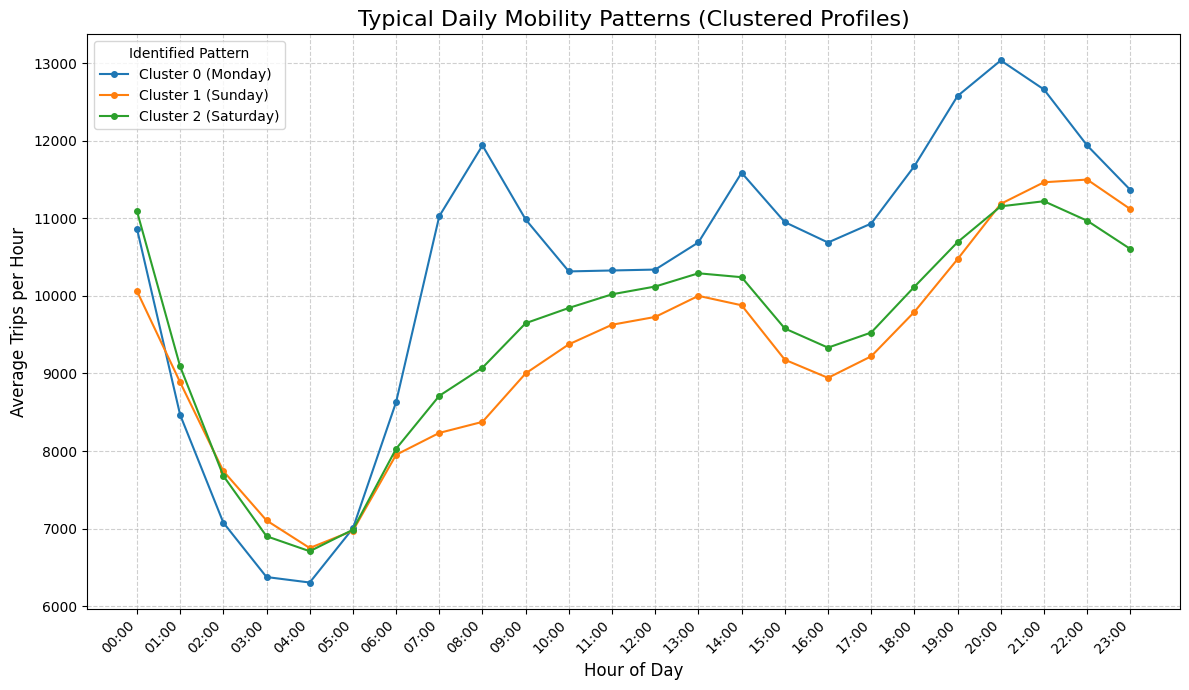

In [48]:
import matplotlib.pyplot as plt

# --- Query the data for plotting ---
print("Querying typical day demand data...")

# 1. RE-REGISTER the view 
# (Necessary because the previous cell unregistered it, but we need it to calculate labels)
con.register('view_dim_clusters', df_results)

# 2. Query: Calculate labels dynamically from the view and join with the Gold table
query = """
WITH cluster_labels AS (
    SELECT 
        cluster_id, 
        -- Calculate day name on the fly since we are using the view
        MODE(dayname(date)) as label
    FROM view_dim_clusters
    GROUP BY cluster_id
)
SELECT 
    t.hour,
    -- Create a readable label for the legend: "Cluster 0 (Sunday)"
    'Cluster ' || t.cluster_id || ' (' || l.label || ')' as pattern_name,
    t.avg_trips
FROM lakehouse.gold.typical_day_by_cluster t
JOIN cluster_labels l ON t.cluster_id = l.cluster_id
ORDER BY t.hour;
"""

demand_df = con.execute(query).df()

if demand_df.empty:
    print("ERROR: 'gold.typical_day_by_cluster' table is empty. No data to plot.")
else:
    # --- Prepare data for plotting ---
    print("Pivoting data for plotting...")
    # Pivot: Index=Hour, Columns=Pattern Name, Values=Average Trips
    pivot_df = demand_df.pivot(index='hour', columns='pattern_name', values='avg_trips')
    
    # --- Create the plot ---
    print("Generating plot with matplotlib...")
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot the data
    pivot_df.plot(kind='line', ax=ax, marker='o', markersize=4)
    
    ax.set_title('Typical Daily Mobility Patterns (Clustered Profiles)', fontsize=16)
    ax.set_xlabel('Hour of Day', fontsize=12)
    ax.set_ylabel('Average Trips per Hour', fontsize=12)
    
    # Set x-ticks to be clear
    ax.set_xticks(range(0, 24))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add legend
    ax.legend(title='Identified Pattern')
    
    # Ensure labels are not cut off
    plt.tight_layout()
    
    # Display the plot in the notebook
    plt.show()

# Optional: Clean up again if you want to keep memory clean
con.unregister('view_dim_clusters')

#### Business Question 2: Infrastructure Gaps

In [49]:
# Instalar y cargar la extensión espacial
con.execute("INSTALL 'spatial';")
con.execute("LOAD 'spatial';")

In [50]:
print("Creating Gold table 'gold_infrastructure_gaps'...")

# Esta consulta responde a la Pregunta de Negocio 2
gold_bq2_query = """--sql
CREATE OR REPLACE TABLE lakehouse.gold.gold_infrastructure_gaps AS

WITH od_pairs AS (
    SELECT
        origin_zone_id,
        destination_zone_id,
        SUM(trips) AS total_actual_trips
    FROM lakehouse.silver.fact_mobility
    GROUP BY 1, 2
),

model_calculation AS (
    SELECT
        m.origin_zone_id AS org_zone_id,
        m.destination_zone_id AS dest_zone_id,
        p.population AS total_population,                     -- P_i
        r.income_per_capita AS rent,              -- E_j
        m.total_actual_trips AS total_trips,                    -- Viajes reales
        
        -- Calcular distancia (d_ij) en KM usando la extensión espacial
        -- Usamos GREATEST(0.5, ...) para evitar distancias de 0 (ej. viajes en la misma zona)
        -- y así prevenir errores de división por cero.
        GREATEST(
            0.5, -- Distancia mínima de 0.5 km
            st_distance_spheroid(
                st_point(c_org.longitude, c_org.latitude), 
                st_point(c_dest.longitude, c_dest.latitude)
            ) / 1000 -- Convertir metros (salida de st_distance) a KM
        ) AS geographic_distance_km             -- d_ij
            
    FROM od_pairs AS m
    JOIN lakehouse.silver.metric_population AS p ON m.origin_zone_id = p.zone_id
    JOIN lakehouse.silver.metric_ine_rent AS r ON m.destination_zone_id = r.zone_id
    JOIN lakehouse.silver.dim_coordinates as c_org ON m.origin_zone_id = c_org.zone_id
    JOIN lakehouse.silver.dim_coordinates as c_dest ON m.destination_zone_id = c_dest.zone_id

    
    -- Filtramos datos malos para evitar errores en el modelo
    WHERE p.population > 0 
      AND r.income_per_capita > 0
      AND c_org.latitude IS NOT NULL
      AND c_dest.latitude IS NOT NULL
      AND m.origin_zone_id != m.destination_zone_id -- Evitar viajes dentro de la misma zona
)

-- Calcular el modelo final y el mismatch
SELECT
    org_zone_id,
    dest_zone_id,
    total_trips,
    total_population,
    rent,
    geographic_distance_km,
    
    -- Calcular Modelo de Gravedad T_ij = k * (P_i * E_j) / (d_ij^2)
    -- Asumimos k=1 para este PoC del Sprint 1
    (1.0 * (CAST(total_population AS DOUBLE) * CAST(rent AS DOUBLE))) / 
    (geographic_distance_km * geographic_distance_km) AS estimated_potential_trips, -- T_ij
        
    -- Calcular Mismatch Ratio 
    -- (Viajes Reales / Viajes Estimados)
    total_trips / NULLIF(estimated_potential_trips, 0) AS mismatch_ratio

FROM model_calculation;
"""

con.execute(gold_bq2_query)
print("✓ Tabla 'gold.gold_infrastructure_gaps' creada.")

# --- Verificación ---
print("\n--- Verificación BQ2: Top 10 Zonas con 'Mismatch' (potencialmente peor servidas) ---")
verification_bq2 = """--sql
    SELECT 
        org_zone_id,
        dest_zone_id,
        total_trips,
        estimated_potential_trips,
        geographic_distance_km,
        mismatch_ratio
    FROM lakehouse.gold.gold_infrastructure_gaps
    WHERE total_trips > 10 -- Filtrar pares con muy pocos viajes
    AND org_zone_id != dest_zone_id -- Evitar viajes dentro de la misma zona
    ORDER BY mismatch_ratio ASC -- Ordenamos por ratio más bajo (peor servicio)
    LIMIT 10;
"""
display(con.execute(verification_bq2).df())

Creating Gold table 'gold_infrastructure_gaps'...
✓ Tabla 'gold.gold_infrastructure_gaps' creada.

--- Verificación BQ2: Top 10 Zonas con 'Mismatch' (potencialmente peor servidas) ---


,org_zone_id,dest_zone_id,total_trips,estimated_potential_trips,geographic_distance_km,mismatch_ratio
0,2402,1131,20.0,175243.733577,286.649366,0.000114
1,2402,1131,20.0,165834.222517,286.649366,0.000121
2,2402,1131,20.0,165103.759962,286.649366,0.000121
3,2402,1131,20.0,160884.377576,286.649366,0.000124
4,2402,1131,20.0,157866.413865,286.649366,0.000127
5,2402,1131,20.0,157203.230757,286.649366,0.000127
6,2402,1131,20.0,154339.048636,286.649366,0.000130
7,2402,1131,20.0,144718.087889,286.649366,0.000138
8,2402,1131,20.0,132002.272635,286.649366,0.000152
9,383,2124,22.0,121824.542840,121.049203,0.000181


In [51]:
print("\n--- Verificación BQ2: Top 10 Zonas con 'Mismatch' (potencialmente peor servidas) ---")
verification_bq2 = """--sql
    SELECT 
        org_zone_id,
        dest_zone_id,
        total_trips,
        estimated_potential_trips,
        geographic_distance_km,
        mismatch_ratio
    FROM lakehouse.gold.gold_infrastructure_gaps
    WHERE total_trips > 10 -- Filtrar pares con muy pocos viajes
    ORDER BY mismatch_ratio ASC -- Ordenamos por ratio más bajo (peor servicio)
    LIMIT 15;
"""
display(con.execute(verification_bq2).df())


--- Verificación BQ2: Top 10 Zonas con 'Mismatch' (potencialmente peor servidas) ---


,org_zone_id,dest_zone_id,total_trips,estimated_potential_trips,geographic_distance_km,mismatch_ratio
0,2402,1131,20.0,175243.733577,286.649366,0.000114
1,2402,1131,20.0,165834.222517,286.649366,0.000121
2,2402,1131,20.0,165103.759962,286.649366,0.000121
3,2402,1131,20.0,160884.377576,286.649366,0.000124
4,2402,1131,20.0,157866.413865,286.649366,0.000127
5,2402,1131,20.0,157203.230757,286.649366,0.000127
6,2402,1131,20.0,154339.048636,286.649366,0.000130
7,2402,1131,20.0,144718.087889,286.649366,0.000138
8,2402,1131,20.0,132002.272635,286.649366,0.000152
9,383,2124,22.0,121824.542840,121.049203,0.000181


# Close connection

In [ ]:
con.close()